In [890]:
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import yen
from scipy.sparse import csr_matrix
import pandas as pd
import ast

#### *Load Network Topology*

In [891]:
# Load the .mat file
mat_data = scipy.io.loadmat(r".\MAN157Nodes.mat")

# Display the keys in the loaded dictionary
print(mat_data.keys())

net_topology = mat_data['MAN157Nodes']
net_topology_ex = net_topology.copy()

print('the type of net_topology:', type(net_topology_ex))

topo_size = net_topology_ex.shape
print('the shape of net_topology: ', topo_size)

dict_keys(['__header__', '__version__', '__globals__', 'MAN157Nodes'])
the type of net_topology: <class 'numpy.ndarray'>
the shape of net_topology:  (157, 157)


In [892]:
# Make the adjacenccy matrix upper triangular
net_topology_ex = np.triu(net_topology_ex)

In [893]:
# Create graph from adjacency matrix
net_graph = nx.from_numpy_array(net_topology_ex)

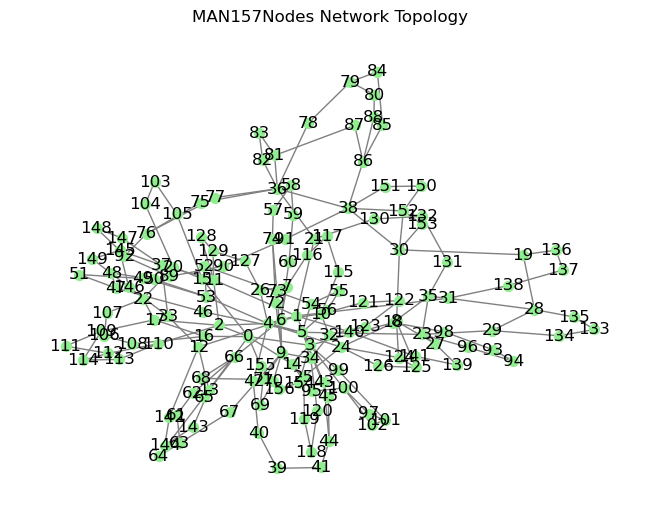

In [894]:
# Draw the graph
nx.draw(net_graph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', edge_color='gray', node_size = 50)
plt.title('MAN157Nodes Network Topology')
plt.show()

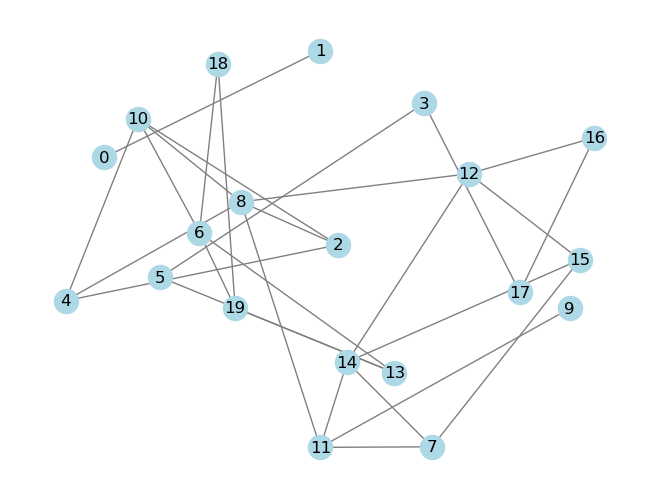

In [895]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.random_geometric_graph(20, 0.3)  # Example graph

# pos = nx.spring_layout(G, k=100, iterations=100)  # Adjust k for spacing
pos = nx.spring_layout(G, k=1.5)  # Increase k for more spacing

nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')

plt.show()


#### *Extract all source-destination-weight pairs*

In [896]:
src_des_weight = list(net_graph.edges(data = 'weight'))
src_des_weight_matrix = np.array(src_des_weight)

print('the shape of source-destination-weight matrix:', src_des_weight_matrix.shape)

the shape of source-destination-weight matrix: (220, 3)


##### *Some statistical analysis of links*

In [897]:
num_links = src_des_weight_matrix.shape[0]

print('number of links:', num_links)
print('maximum link weight:', src_des_weight_matrix[:, 2].max())
print('maximum link weight:', src_des_weight_matrix[:, 2].min())
print('average link weight:', src_des_weight_matrix[:, 2].mean())

number of links: 220
maximum link weight: 65.67
maximum link weight: 0.7
average link weight: 11.137363636363638


##### *Calculate the number of optical amplifier spans required for signal transmission*

In [898]:
# Define span length of 70 km
span_length = 70

# Calculate the number of spans required for each link
num_spans_per_link = np.ceil(src_des_weight_matrix[:, 2] / span_length)

#### *Node categorization into hierarchical levels*

In [899]:
# manually assign nodes 2 and 6 into HL1 level
HL1_StandAlone = np.array([1, 5])

# manually assign nodes [0 2 3 4] into HL1 level
HL2_StandAlone = np.array([0, 2, 3, 4])

# manually assign nodes 6 to 38 into HL1 level
HL3_StandAlone = np.arange(6, 39)

# manually assign nodes 39:topo_size(1) into HL1 level
HL4_StandAlone = np.arange(39, topo_size[1])

# concatenated HL1, HL2, HL3 nodes
HL123_standalone = np.concatenate((HL1_StandAlone, HL2_StandAlone, HL3_StandAlone))

# there is a colocated HL4 router in each upper level routers (HL1, HL2, HL3)
HL4_colocated = np.sort(HL123_standalone)

# concatenate all HL4 nodes consist of standalone and colocated
HL4_all = np.concatenate((HL4_colocated, HL4_StandAlone))

# there is colocated HL3 routers in HL1 and HL2 nodes
HL3_colocated = np.concatenate((HL1_StandAlone, HL2_StandAlone))

# there is colocated HL2 routers in HL1 nodes
HL2_colocated = HL1_StandAlone

##### *Calculate node degree of each hierarchical level nodes*


In [900]:
# Create a subgraph containing only edges where at least one node is in HL4 standalone
edges_in_subgraph = [(u, v) for u, v in net_graph.edges if u in HL4_StandAlone or v in HL4_StandAlone]

# calculate HL4 subnet graphs
HL4_subgraph = net_graph.edge_subgraph(edges_in_subgraph).copy()

# calculate node degree of different HLx
HL4_degrees = np.array(net_graph.degree(HL4_StandAlone))
HL3_degrees = np.array(net_graph.degree(HL3_StandAlone))
HL2_degrees = np.array(net_graph.degree(HL2_StandAlone))
HL1_degrees = np.array(net_graph.degree(HL1_StandAlone))

##### *Some statistical analysis of node degrees*

In [901]:
print('maximum node degree of HL4 routers:', HL4_degrees.max(axis = 0)[1])
print('minimum node degree of HL4 routers:', HL4_degrees.min(axis = 0)[1])
print('average node degree of HL4 routers:', HL4_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL3 routers:', HL3_degrees.max(axis = 0)[1])
print('minimum node degree of HL3 routers:', HL3_degrees.min(axis = 0)[1])
print('average node degree of HL3 routers:', HL3_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL2 routers:', HL2_degrees.max(axis = 0)[1])
print('minimum node degree of HL2 routers:', HL2_degrees.min(axis = 0)[1])
print('average node degree of HL2 routers:', HL2_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')

print('maximum node degree of HL1 routers:', HL1_degrees.max(axis = 0)[1])
print('minimum node degree of HL1 routers:', HL1_degrees.min(axis = 0)[1])
print('average node degree of HL1 routers:', HL1_degrees.mean(axis = 0)[1])
print('-----------------------------------------------------------------')


maximum node degree of HL4 routers: 5
minimum node degree of HL4 routers: 2
average node degree of HL4 routers: 2.2711864406779663
-----------------------------------------------------------------
maximum node degree of HL3 routers: 8
minimum node degree of HL3 routers: 3
average node degree of HL3 routers: 3.9393939393939394
-----------------------------------------------------------------
maximum node degree of HL2 routers: 8
minimum node degree of HL2 routers: 5
average node degree of HL2 routers: 6.75
-----------------------------------------------------------------
maximum node degree of HL1 routers: 8
minimum node degree of HL1 routers: 7
average node degree of HL1 routers: 7.5
-----------------------------------------------------------------


#### *Plot HL4 subnet graph*

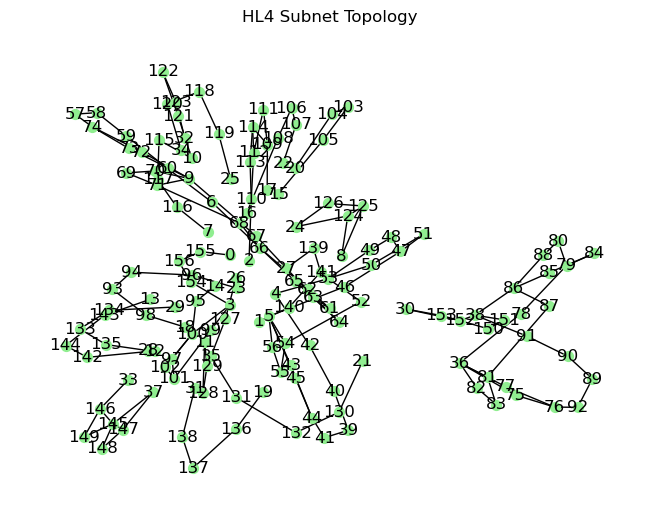

In [902]:
nx.draw(HL4_subgraph, pos = nx.spring_layout(net_graph), with_labels = True, node_color = 'lightgreen', node_size = 50)
plt.title('HL4 Subnet Topology')
plt.show()

#### *Define Cost Matrices*

In [903]:
# Define cost matrix of whole network
netCostMatrix = nx.to_numpy_array(net_graph, weight='weight', nonedge = np.inf)

# Define cost matrix of HL4 subnet
netCostMatrix_HL4 = nx.to_numpy_array(HL4_subgraph, weight='weight', nonedge = np.inf)

#### *Define some parameters*

In [904]:
# define target BER
target_ber = 1e-2

# multi-format loss factors - commented suggest no loss cosideration
phi_MFL =  -1 * [1, 1, 2/3, 17/25, 69/100, 13/21]
# phi_MFL = zeros(1, 6);

epsilon = 0

# define third-order dispersion coefficient
beta_3 = 0.14e-39
Cr = 0.028 / 1e3 / 1e12

# define attenuation coeff (dB/km)
alpha_db = 0.2

# normalized attenuation coeff
alpha_norm = alpha_db / (10 * np.log10(np.exp(1)) * 1e3)

# group velocity dispersion (s^2/m)
beta_2 = -21.7e-27

# define nonlinear parameter (1/(W.m)
gama = 1.21e-3

L_eff_a = 1 / alpha_norm

# noise figure 6 dB
F_C = np.power(10, 0.45)    
F_L = np.power(10, 0.5)         

# Planck's constant (J s)
h_plank = 6.626e-34   

# L_eff is defined as (1 - e ^ (alpha * L_s)) / alpha
L_eff=(1 - np.exp(-1 * alpha_norm * span_length)) / (alpha_norm)


#### *Calculate all HL1, HL2, HL3 nodes that have any connection to HL4s*

In [905]:
# define set to avoid duplicates
HL4_connected_nodes = set() 
for node in HL4_StandAlone:
    HL4_connected_nodes.update(net_graph.neighbors(node))

# Remove the target nodes themselves from the result
HL4_connected_nodes -= set(HL4_StandAlone)

print("Connected higher hierarchical nodes to HL4s:\n", HL4_connected_nodes)

Connected higher hierarchical nodes to HL4s:
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}


#### *K pair link- and node-disjoint shortest paths for HL4 nodes by using DLN_Algorithm*

> ##### Note: *for standalone HL4s we have the primary and secondary, but for colocated HL4 we have only secondary paths. (primary is in it's node)*
> ##### *K_path_attributes's columns --> | 1: source node | 2: destination node | 3: nodes list | 4: distance | 5: links list | 6: number of hops*

##### *Standalone HL4s*

*Define a function to extract all nodes in a certain path*

In [906]:
def nodes_in_path(predecessors, path_index, source, target):
    """Reconstructs the i-th shortest path from the predecessors matrix."""
    path = []
    node = target
    while node != -9999 and node != source:
        path.append(node)
        node = predecessors[path_index, node]
    if node != -9999:
        path.append(source)
        return path[::-1]  # Reverse path to get source-to-target order
    return []  # No path found

*Define a function to extract all links in a certain path*

In [907]:
def links_in_path(all_links, path):
    links_array = []
    for i in range(len(path)):
        if i != len(path) - 1:
            link_idx = np.where(((all_links[:, 0] == path[i]) & (all_links[:, 1] == path[i + 1])) | ((all_links[:, 0] == path[i + 1]) & (all_links[:, 1] == path[i])))[0]
            links_array.append(link_idx[0])

    return links_array

*Calculate K_shortest path between standalone HL4s and possible destinations*

In [908]:
# # create scipy graph to use Yen algorithm
# graph = csr_matrix(netCostMatrix_HL4)

# # all links in the whole network array
# all_links = np.array(list(net_graph.edges(data = 'weight')))

# # define how many paths will calc between each source-destination pair
# k_paths = 20

# # define a list to store path attributes
# K_path_attributes = []

# # iterate through each standalone HL4 node
# for src in HL4_StandAlone:

#     for dest in HL4_connected_nodes:
#         local_dict = {}
#         # print(src, dest)
#         # K_path_attributes.append(local_dict)
#         dist_array, predecessors = yen(csgraph = graph, source = src, sink = dest, K = k_paths, directed = False, return_predecessors = True)

#         # Reconstruct and display all paths
#         for candidate_path, dist in enumerate(dist_array):
#             path = nodes_in_path(predecessors, candidate_path, src, dest)
#             links_array = links_in_path(all_links, path)
#             local_dict = {}
#             local_dict['src_node'] = src
#             local_dict['dest_node'] = dest
#             local_dict['nodesList'] = path
#             local_dict['distance'] = dist
#             local_dict['linksList'] = links_array
#             local_dict['numHops'] = len(path) - 1

#             K_path_attributes.append(local_dict)
            

# # Convert K_path_attributes list to dataframe
# df = pd.DataFrame(K_path_attributes)

# # save dataframe to csv file
# df.to_csv(r'.\K_path_attributes.csv', index = False)


*Note: we calculate the K_shortest_path once, after that just load the csv file*

In [909]:
K_path_attributes_df = pd.read_csv(r'.\K_path_attributes.csv')
K_path_attributes_df['linksList'] = K_path_attributes_df['linksList'].apply(ast.literal_eval)
K_path_attributes_df['nodesList'] = K_path_attributes_df['nodesList'].apply(ast.literal_eval)

*Check for the first 5 rows of the dataframe*

In [910]:
K_path_attributes_df

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[118, 120, 27]",3
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[119, 121, 123, 31, 33, 132, 131, 28]",8
2,39,4,"[39, 41, 44, 43, 5, 54, 52, 53, 4]",80.2,"[119, 121, 122, 30, 33, 132, 131, 28]",8
3,39,4,"[39, 41, 44, 45, 5, 46, 47, 51, 50, 53, 4]",85.7,"[119, 121, 123, 31, 32, 124, 126, 129, 130, 28]",10
4,39,4,"[39, 41, 44, 43, 5, 46, 47, 51, 50, 53, 4]",86.7,"[119, 121, 122, 30, 32, 124, 126, 129, 130, 28]",10
...,...,...,...,...,...,...
1730,156,0,"[156, 155, 0]",32.0,"[219, 6]",2
1731,156,3,"[156, 154, 3]",30.0,"[218, 23]",2
1732,156,14,"[156, 154, 3, 100, 95, 14]",66.0,"[218, 23, 22, 172, 64]",5
1733,156,14,"[156, 154, 3, 99, 101, 102, 100, 95, 14]",91.0,"[218, 23, 21, 175, 177, 176, 172, 64]",8


*Filter out all the paths from the source 39 to destination 4*

In [911]:
K_path_attributes_df[(K_path_attributes_df['src_node'] == 39)]

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[118, 120, 27]",3
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[119, 121, 123, 31, 33, 132, 131, 28]",8
2,39,4,"[39, 41, 44, 43, 5, 54, 52, 53, 4]",80.2,"[119, 121, 122, 30, 33, 132, 131, 28]",8
3,39,4,"[39, 41, 44, 45, 5, 46, 47, 51, 50, 53, 4]",85.7,"[119, 121, 123, 31, 32, 124, 126, 129, 130, 28]",10
4,39,4,"[39, 41, 44, 43, 5, 46, 47, 51, 50, 53, 4]",86.7,"[119, 121, 122, 30, 32, 124, 126, 129, 130, 28]",10
5,39,4,"[39, 41, 44, 45, 5, 56, 55, 54, 52, 53, 4]",99.2,"[119, 121, 123, 31, 34, 134, 133, 132, 131, 28]",10
6,39,4,"[39, 41, 44, 43, 5, 56, 55, 54, 52, 53, 4]",100.2,"[119, 121, 122, 30, 34, 134, 133, 132, 131, 28]",10
7,39,4,"[39, 41, 44, 45, 5, 46, 47, 48, 49, 53, 4]",106.0,"[119, 121, 123, 31, 32, 124, 125, 127, 128, 28]",10
8,39,4,"[39, 41, 44, 43, 5, 46, 47, 48, 49, 53, 4]",107.0,"[119, 121, 122, 30, 32, 124, 125, 127, 128, 28]",10
9,39,5,"[39, 41, 44, 45, 5]",37.0,"[119, 121, 123, 31]",4


##### *Colocated HL4s*

In [912]:
# # define how many paths will calc between each source-destination pair
# k_paths = 20

# # define a list to store path attributes
# K_path_attributes_colocated = []

# # iterate through each colocated HL4 node
# for src in HL4_colocated:

#     for dest in HL4_connected_nodes:
#         local_dict = {}

#         if src != dest:
            
#             # K_path_attributes.append(local_dict)
#             dist_array, predecessors = yen(csgraph = graph, source = src, sink = dest, K = k_paths, directed = False, return_predecessors = True)

#             # Reconstruct and display all paths
#             for candidate_path, dist in enumerate(dist_array):
#                 path = nodes_in_path(predecessors, candidate_path, src, dest)
#                 links_array = links_in_path(all_links, path)

#                 local_dict = {}
#                 local_dict['src_node'] = src
#                 local_dict['dest_node'] = dest
#                 local_dict['nodesList'] = path
#                 local_dict['distance'] = dist
#                 local_dict['linksList'] = links_array
#                 local_dict['numHops'] = len(path) - 1

#                 K_path_attributes_colocated.append(local_dict)

# # Convert K_path_attributes list to dataframe
# df = pd.DataFrame(K_path_attributes_colocated)

# # save dataframe to csv file
# df.to_csv(r'.\K_path_attributes_colocated.csv', index = False)


*Note: we calculate the K_shortest_path once, after that just load the csv file*

In [913]:
K_path_attributes_colocated_df = pd.read_csv(r'.\K_path_attributes_colocated.csv')
K_path_attributes_colocated_df['linksList'] = K_path_attributes_colocated_df['linksList'].apply(ast.literal_eval)
K_path_attributes_colocated_df['nodesList'] = K_path_attributes_colocated_df['nodesList'].apply(ast.literal_eval)

*Check for the first 5 rows of the dataframe*

In [914]:
K_path_attributes_colocated_df.head()

,src_node,dest_node,nodesList,distance,linksList,numHops
0,0,3,"[0, 155, 156, 154, 3]",62.0,"[6, 219, 218, 23]",4
1,0,14,"[0, 155, 156, 154, 3, 100, 95, 14]",98.0,"[6, 219, 218, 23, 22, 172, 64]",7
2,0,14,"[0, 155, 156, 154, 3, 99, 101, 102, 100, 95, 14]",123.0,"[6, 219, 218, 23, 21, 175, 177, 176, 172, 64]",10
3,0,14,"[0, 155, 156, 154, 3, 99, 101, 97, 100, 95, 14]",125.0,"[6, 219, 218, 23, 21, 175, 174, 173, 172, 64]",10
4,1,27,"[1, 140, 141, 139, 27]",33.0,"[13, 206, 205, 90]",4


*Filter out all the paths from the source 39 to destination 4*

In [915]:
K_path_attributes_colocated_df[(K_path_attributes_colocated_df['src_node'] == 24)]

,src_node,dest_node,nodesList,distance,linksList,numHops
67,24,8,"[24, 124, 8]",9.0,"[86, 45]",2
68,24,8,"[24, 124, 125, 8]",16.0,"[86, 195, 46]",3
69,24,8,"[24, 126, 125, 8]",21.0,"[87, 196, 46]",3
70,24,8,"[24, 126, 125, 124, 8]",30.0,"[87, 196, 195, 45]",4


*Plot the subnet topology for double check*

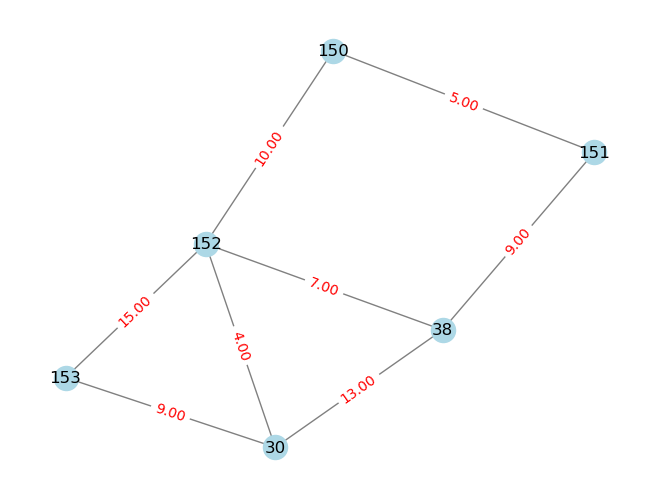

In [916]:
nodes = np.array([38, 151, 150, 152, 153, 30])
sub_net_local = net_graph.subgraph(nodes)

pos = nx.spring_layout(sub_net_local)  # Use full graph positions for consistency
nx.draw(sub_net_local, pos, with_labels=True, node_color='lightblue', edge_color='gray')

# plot the weights of edges on the graph
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in sub_net_local.edges(data=True)}
nx.draw_networkx_edge_labels(sub_net_local, pos, edge_labels=edge_labels, font_color='red')

plt.show()

#### *Calculate Primary and Secondary paths of each source-destination pair*

##### *Standalone HL4s*

*Sort the K_path_attribute dataframe based on numHops and distance in order*

In [917]:
K_paths_sorted = K_path_attributes_df.groupby(['src_node'], group_keys = False).apply(lambda x: x.sort_values(['numHops', 'distance']))

*Check for the first 5 sorted path*

In [918]:
K_paths_sorted.head()

,src_node,dest_node,nodesList,distance,linksList,numHops
0,39,4,"[39, 40, 42, 4]",30.0,"[118, 120, 27]",3
9,39,5,"[39, 41, 44, 45, 5]",37.0,"[119, 121, 123, 31]",4
10,39,5,"[39, 41, 44, 43, 5]",38.0,"[119, 121, 122, 30]",4
11,39,5,"[39, 40, 42, 4, 53, 52, 54, 5]",72.2,"[118, 120, 27, 28, 131, 132, 33]",7
1,39,4,"[39, 41, 44, 45, 5, 54, 52, 53, 4]",79.2,"[119, 121, 123, 31, 33, 132, 131, 28]",8


*Calculate all secondary paths for each path in the dataframe*

> *Note: The secondary paths must be fully disjoint, means don't have shared nodes or links with the primary path*

In [919]:
# standalone_path_storage = []
# primary_path_storage = []
# secondary_path_Storage = []
# numHops_secondary_storage = []
# distance_secondary_storage = []

# # iterate through each standalone HL4 node
# for node in HL4_StandAlone:
#     # print(node)
#     node_df = K_paths_sorted[K_paths_sorted['src_node'] == node]

#     # print('node_df', node_df)

#     # iterate through each paths of the selected source node
#     for index, row in node_df.iterrows():

#         # print("secondary_path_Storage:", secondary_path_Storage)

#         # check for repeated pairs
#         if any(x == index for x in secondary_path_Storage):
#             break


#         # extract the information of primary path
#         dest_primary = row['dest_node']
#         nodes_primary = row['nodesList']
#         links_primary = row['linksList']

#         # print('primary_index:', index)
        
#         # calculate all candidate secondary paths, they must have different destinations of primary path
#         secondary_df = node_df[node_df['dest_node'] != dest_primary]

#         # iterate through each candidate secondary path
#         for index_secondary, row_secondary in secondary_df.iterrows():

#             # extract the information of candidate secondary path
#             nodes_secondary = row_secondary['nodesList']
#             links_secondary = row_secondary['linksList']

#             # check for the common nodes and links of primary and candidate secondary paths
#             common_nodes = np.intersect1d(nodes_primary, nodes_secondary)
#             common_links = np.intersect1d(links_primary, links_secondary)


#             # there is one common node always that is src_node
#             if common_nodes.size == 1 and common_links.size == 0:

#                 # save the primary path and approved secondary path indices to separate lists
#                 primary_path_storage.append(index)
#                 secondary_path_Storage.append(index_secondary)

#                 # print('secondary_index:', index_secondary)

#                 # save numHops and distance of approved secondary path to separate lists
#                 numHops_secondary_storage.append(row_secondary['numHops'])
#                 distance_secondary_storage.append(row_secondary['distance'])

# # save all the standalone paths in one array
# standalone_path_storage.append(primary_path_storage) # first row is primary path indices
# standalone_path_storage.append(secondary_path_Storage) # second row is approved secondary path indices
# standalone_path_storage.append(numHops_secondary_storage) # third row is numHops of approved secondary paths
# standalone_path_storage.append(distance_secondary_storage) # fourth row is distance of approved secondary paths

# standalone_path_storage = np.array(standalone_path_storage)

# # convert numpy array of primary-secondary pairs to a dataframe
# standalone_path_df = pd.DataFrame(standalone_path_storage.T, columns = ['primary_path', 'secondary_path', 'numHops_secondary', 'distance_secondary'])

# # save the standalone dataframe
# standalone_path_df.to_csv(r'.\standalone_paths.csv', index = False)

*Load the standalone path pairs dataframe*

In [920]:
standalone_path_df = pd.read_csv(r'.\standalone_paths.csv')

In [921]:
standalone_path_df

,primary_path,secondary_path,numHops_secondary,distance_secondary
0,0.0,9.0,4.0,37.0
1,0.0,10.0,4.0,38.0
2,15.0,24.0,5.0,47.0
3,15.0,25.0,5.0,48.0
4,39.0,30.0,4.0,35.5
...,...,...,...,...
280,1725.0,1726.0,3.0,46.0
281,1725.0,1727.0,6.0,82.0
282,1725.0,1728.0,9.0,107.0
283,1725.0,1729.0,9.0,109.0


*Count the number of secondary paths for each primary path*

In [922]:
print(standalone_path_df.groupby('primary_path')['secondary_path'].count())

primary_path
0.0        2
15.0       2
39.0       1
40.0       1
45.0       2
          ..
1678.0    14
1694.0    11
1721.0     1
1725.0     4
1731.0     1
Name: secondary_path, Length: 129, dtype: int64


*Add src_node column to filtered_standalone_df*

In [923]:
standalone_path_df

,primary_path,secondary_path,numHops_secondary,distance_secondary
0,0.0,9.0,4.0,37.0
1,0.0,10.0,4.0,38.0
2,15.0,24.0,5.0,47.0
3,15.0,25.0,5.0,48.0
4,39.0,30.0,4.0,35.5
...,...,...,...,...
280,1725.0,1726.0,3.0,46.0
281,1725.0,1727.0,6.0,82.0
282,1725.0,1728.0,9.0,107.0
283,1725.0,1729.0,9.0,109.0


In [924]:
standalone_path_df = standalone_path_df.merge(K_path_attributes_df['src_node'].reset_index(), 
                                                      left_on='primary_path', right_on='index', how='left').drop(columns=['index'])

In [925]:
standalone_path_df.head()

,primary_path,secondary_path,numHops_secondary,distance_secondary,src_node
0,0.0,9.0,4.0,37.0,39
1,0.0,10.0,4.0,38.0,39
2,15.0,24.0,5.0,47.0,40
3,15.0,25.0,5.0,48.0,40
4,39.0,30.0,4.0,35.5,41


*Calculate all available standalone HL4*
> *not available nodes doesn't have primary-secondary path at all (with k_path = 10).*

In [926]:
available_HL4_standalone_nodes = standalone_path_df['src_node'].unique()

*Calculate not available standalone HL4s*

In [927]:
nonavailable_standalone_HL4 = np.setdiff1d(HL4_StandAlone, available_HL4_standalone_nodes)

*Calculate the number of primary-secondary pairs available for each standalone HL4 nodes*

In [928]:
num_K_pair_final = standalone_path_df.groupby('src_node')['primary_path'].count().to_numpy()

*Find the index of nonavailable standalone HL4s in standalone HL4 nodes*

In [929]:
indices = [np.where(HL4_StandAlone == val)[0][0] if val in HL4_StandAlone else -1 for val in nonavailable_standalone_HL4]

*Insert zero to the index of nonavailable standalone HL4 nodes*

In [930]:
num_K_pair_final = np.insert(num_K_pair_final, indices, 0)

In [931]:
num_K_pair_final

array([ 2,  2,  2,  2,  1,  2,  1,  2,  2,  1,  1,  1,  1,  1,  4,  1,  1,
        1,  2,  2,  2,  2,  1,  1,  2,  1,  1,  4,  2,  1,  1,  1,  1,  1,
        1,  2,  4,  8,  4,  9, 10,  5,  5,  5,  5,  5,  1,  4,  5,  1,  2,
        4,  8, 10,  1,  1,  6,  1,  1,  1,  2,  1,  2,  2,  1,  1,  1,  1,
        1,  1,  4,  4,  2,  2,  2,  2,  1,  2,  1,  1,  1,  1,  1,  1,  2,
        2,  2,  2,  2,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  2,  6,  4,  2,  3,  7,  2, 14, 11,  1,  4,  1],
      dtype=int64)

##### *Colocated HL4s*

> *Note: for the colocated HL4s there are only secondary paths*

*Sort the K_path_attribute_colocated dataframe based on numHops and distance in order*

In [932]:
K_paths_sorted_colocated = K_path_attributes_colocated_df.groupby(['src_node', 'dest_node'], group_keys = False).apply(lambda x: x.sort_values(['numHops', 'distance']))

In [933]:
K_paths_sorted_colocated

,src_node,dest_node,nodesList,distance,linksList,numHops
0,0,3,"[0, 155, 156, 154, 3]",62.0,"[6, 219, 218, 23]",4
1,0,14,"[0, 155, 156, 154, 3, 100, 95, 14]",98.0,"[6, 219, 218, 23, 22, 172, 64]",7
2,0,14,"[0, 155, 156, 154, 3, 99, 101, 102, 100, 95, 14]",123.0,"[6, 219, 218, 23, 21, 175, 177, 176, 172, 64]",10
3,0,14,"[0, 155, 156, 154, 3, 99, 101, 97, 100, 95, 14]",125.0,"[6, 219, 218, 23, 21, 175, 174, 173, 172, 64]",10
4,1,27,"[1, 140, 141, 139, 27]",33.0,"[13, 206, 205, 90]",4
...,...,...,...,...,...,...
149,38,36,"[38, 86, 85, 84, 79, 78, 36]",48.7,"[114, 163, 162, 157, 155, 109]",6
150,38,36,"[38, 86, 87, 81, 83, 82, 36]",62.2,"[114, 164, 160, 159, 161, 111]",6
153,38,36,"[38, 86, 88, 80, 79, 78, 36]",69.0,"[114, 165, 158, 156, 155, 109]",6
151,38,36,"[38, 91, 90, 89, 92, 76, 75, 36]",67.0,"[115, 168, 166, 167, 154, 152, 107]",7


> *There are 5 paths between each colocated source-node pair*

#### *Simulating aggregated traffic at HL4s*

##### *generate port capacity for HL4 nodes uisng Monte Carlo simulation*

In [934]:
monteCarlo_steps = 100
min_HL4_rate = 20
max_HL4_rate = 200

# storage for random capacities in each Monte Carlo step
random_capacity_storage = []

for i in range(monteCarlo_steps):

    # set random seed to make our random numbers constant in different runs
    np.random.seed(20)
    # create random capacity for each HL4 node (standalone & colocated) uniformly distributed
    random_capacity_local = np.random.uniform(min_HL4_rate, max_HL4_rate, size = len(HL4_all))
    random_capacity_storage.append(random_capacity_local)

random_capacity_storage = np.array(random_capacity_storage)

# average over Monte Carlo steps to find a final capacity for each HL4 node
HL4_capacity_final = random_capacity_storage.mean(axis = 0)

##### *Traffic growth simulation over 10 years*

In [935]:
# set Compounded Annual Growth Rate (CAGR) at 40% per year
CAGR = 0.4

# simulate traffic for 10 years
period_time = 10

HL4_traffic_storage_annual = np.empty(shape = (period_time, len(HL4_all)))
total_traffic_annual = np.empty(shape = (period_time))
added_traffic_annual = np.empty(shape = (period_time, len(HL4_all)))
num_100G_licence_annual = np.empty(shape = (period_time, len(HL4_all)))
residual_capacity_annual = np.empty(shape = (period_time, len(HL4_all)))

# set the capacity of HL4 nodes for first year
HL4_traffic_storage_annual[0, :] = HL4_capacity_final

# calculate total traffic at the fist year
total_traffic_annual[0] = np.sum(HL4_capacity_final)

# calculate added traffic in compare of last year
added_traffic_annual[0, :] = HL4_capacity_final

# calculate the number of 100G licences for the first year for each HL4 node
num_100G_licence_annual[0, :] = np.ceil(HL4_capacity_final / 100)

# calculate the residual capcacity of 100G licences for each HL4 node at the first year
residual_capacity_annual[0, :] = 100 * num_100G_licence_annual[0, :] - HL4_traffic_storage_annual[0, :]

for year in range(1, period_time):

    # 40% increase in the value of traffic per HL4 node in related to the last yeat
    HL4_traffic_storage_annual[year, :] = (1 + CAGR) * HL4_traffic_storage_annual[year - 1, :]

    # calculate total traffic of this year
    total_traffic_annual[year] = np.sum(HL4_traffic_storage_annual[year, :])

    # calcualte the added traffic in compare of last year
    added_traffic_annual[year, :] = HL4_traffic_storage_annual[year, :] - HL4_traffic_storage_annual[year - 1, :]

    # calculate the number of 100G licences for this year for each HL4 node
    num_100G_licence_annual[year, :] = np.ceil(HL4_traffic_storage_annual[year, :] / 100)

    # calculate the residual capcacity of 100G licences for each HL4 node at this year
    residual_capacity_annual[year, :] = 100 * num_100G_licence_annual[year, :] - HL4_traffic_storage_annual[year, :]


#### *Multi-Year and Multi-Homed K-Pair Link and Node-Disjoint Routing and Spectrum Assignemnt*

##### *Define some parameters*

In [936]:
# define channel spacing (fix grid)
channel_spacing = 0.05 # 50 GHz spacing

# define C-band and L-band frequency slots
spectrum_C = np.flip(np.arange(190.65, 196.675, step = channel_spacing)) # 50 GHz spacing
spectrum_L = np.flip(np.arange(184.525, 190.565, step = channel_spacing)) # 50 GHz spacing

# concatenate C-band and KL-band to a sigle frequency spectrum
spectrum = np.concatenate((spectrum_C, spectrum_L))

# define total number of frequency slots
num_fslots = len(spectrum)

# define modulation formats and rolloff factor
MFL = np.arange(4, 12 + 2, 2)
rolloff = 0.1

# define Symbol Rate (baud rate)
SR = 40 * 1e9

# Maximum bit rate supported per BVT
Max_bit_rate_BVT = np.array([400]) # Gbps

# Forward Error Correction (FEC) Rate
FEC_Rate = Max_bit_rate_BVT * (1e9) / (SR * max(MFL))

# calculates the actual channel bandwidth
B_ch = SR * (1 + rolloff)

# compute required spectral width per channel (rounding up to fit slots) 
Channel_Space_HL4 = np.ceil(B_ch / (channel_spacing * 1e12))  * channel_spacing

# compute required frequency slots per BVT
Required_FS_BVT = np.ceil(B_ch / (channel_spacing * 1e12))

# define a matrix storing Fiber Placement (FP) status for each network edge over time  
Year_FP = np.zeros((period_time, net_graph.number_of_edges()))

# similar to Year_FP, but specifically for HL4 colocated nodes
Year_FP_HL4_colocated =  np.zeros((period_time, len(HL4_colocated)))

# separating Standalone and Co-located HL4 Traffic Data
HL4_standalone_traffic_storage_annual = HL4_traffic_storage_annual[:, len(HL4_colocated):]
HL4_colocated_traffic_storage_annual = HL4_traffic_storage_annual[:, 0:len(HL4_colocated)]

added_traffic_annual_standalone = added_traffic_annual[:, len(HL4_colocated):]
added_traffic_annual_colocated = added_traffic_annual[:, 0:len(HL4_colocated)]

# store unallocated bandwidth (residual traffic) for Standalone HL4s 
Residual_Throughput_BVT_standalone_HL4s = np.zeros((period_time, len(HL4_StandAlone)))

# store unallocated bandwidth (residual traffic) for Co-located HL4s
Residual_Throughput_BVT_colocated_HL4s = np.zeros((period_time, len(HL4_colocated)))

# track the number of BVTs deployed for different spectrum bands each year
HL4_BVT_number_all_annual = np.zeros((period_time, len(Max_bit_rate_BVT)))
HL4_BVT_number_Cband_annual = np.zeros((period_time, len(Max_bit_rate_BVT))) # Traditional optical band
HL4_BVT_number_SuperCband_annual = np.zeros((period_time, len(Max_bit_rate_BVT))) # Extended C-band for higher capacity
HL4_BVT_number_SuperCLband_annual = np.zeros((period_time, len(Max_bit_rate_BVT))) # Includes L-band for extreme capacity scaling

# LSP (Label Switched Path) arrays track optical paths over num_FS and links  
LSP_array = np.zeros((num_fslots, net_graph.number_of_edges(), 20)) # track spectrum allocation for all links
LSP_array_Colocated_HL4s = np.zeros((num_fslots, len(HL4_colocated), 20)) # Specifically tracks lightpaths for co-located HL4s

# track how many optical links are deployed per year in different bands
num_link_LBand_annual = np.zeros(period_time)
num_link_SupCBand_annual = np.zeros(period_time)
num_link_CBand_annual = np.zeros(period_time)

# track how many optical links are deployed per year in different bands
num_links_per_node_annual =  np.zeros((period_time, HL4_subgraph.number_of_edges()))

# track the total new fiber placements for each year
Total_effective_FP_new_annual = np.zeros(period_time)

# store GSNR values for different BVTs over multiple years
GSNR_BVT_array = []

# store GSNR data for HL4 nodes over 10 years
GSNR_HL4_10Year = []

# set the bvt_type
BVT_type = 1

# load the power for maximum throughput of each link
data = scipy.io.loadmat(r".\GSNR_opt_link_HL4_CL.mat")
GSNR_opt_link_HL4_CL = data['GSNR_opt_link_HL4_CL']

# store weights of links
weights_array = np.array(list(net_graph.edges(data = 'weight')))[:, 2]

In [937]:
period_time = 2

In [938]:
storage_list = []

In [939]:
standalone_path_df

,primary_path,secondary_path,numHops_secondary,distance_secondary,src_node
0,0.0,9.0,4.0,37.0,39
1,0.0,10.0,4.0,38.0,39
2,15.0,24.0,5.0,47.0,40
3,15.0,25.0,5.0,48.0,40
4,39.0,30.0,4.0,35.5,41
...,...,...,...,...,...
280,1725.0,1726.0,3.0,46.0,155
281,1725.0,1727.0,6.0,82.0,155
282,1725.0,1728.0,9.0,107.0,155
283,1725.0,1729.0,9.0,109.0,155


In [940]:
for year in range(1 , period_time + 1):
    # storage_dict = {}
    # storage_dict['year'] = year

    print(f"year: {year}")
    # store traffic capacity assigned to each node, in the third dimension 0 is for primary SNR and 1 is for secondary SNR
    node_capacity_profile = np.zeros(shape = (len(HL4_colocated) + len(HL4_StandAlone), 2))

    print('shape:', node_capacity_profile.shape)
    # tracks signal quality (GSNR) per BVT
    GSNR_BVT_per_year = np.zeros(shape = (period_time, len(HL4_StandAlone), 2))

    # storage for LSP_arrays
    LSP_array_pair_storage = []

    # storage for Year_FP
    Year_FP_pair_storage = []

    # Initialize the cost function matrix with infinity values for each metric (f_max, N_hop, cost, GSNR, FP_max)
    cost_func = np.inf * np.ones(shape = (len(HL4_StandAlone), 5))

    # array for saving destinations of standalone nodes in each year, in the third dimension 0 is for primary destination and 1 is for secondary destination
    HL4_standalone_dest_profile = np.zeros(shape = (period_time, len(HL4_StandAlone), 2), dtype = np.int8)

    #######################################################
    # Part 1: Spectrum assignment for standalone HL4s
    #######################################################

    # HL4_StandAlone = np.array([39, 40])

    for node_idx in range(len(HL4_StandAlone)):

        # storage_dict['node'] = HL4_StandAlone[node_idx]

        # get traffic demand for this node in this year
        HL4_needed_traffic = added_traffic_annual_standalone[year - 1, node_idx]
        
        # if it isnt the first year
        if year != 1:
            # subtract residual throughput (unallocated traffic from previous years)
            HL4_pure_throughput_to_assign = HL4_needed_traffic - Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx]

            # store traffic capacity assigned to current node
            node_capacity_profile[HL4_StandAlone[node_idx], 1] = HL4_pure_throughput_to_assign

        else: # if it is the first year
            
            HL4_pure_throughput_to_assign = HL4_needed_traffic
            # store traffic capacity assigned to current node
            node_capacity_profile[HL4_StandAlone[node_idx], 1] = HL4_pure_throughput_to_assign

        # print(f"node cap: {node_capacity_profile}")
        
        #################
        # BVT selection 
        #################
        if HL4_pure_throughput_to_assign > 0:

            # calc reference traffic based on the year
            if year < 5:

                # refference traffic is on the year = 5
                traffic_ref =  HL4_standalone_traffic_storage_annual[4, node_idx]

            elif (year > 5) and (year < 10):

                # refference traffic is the difference of traffic at year 10 and 5
                traffic_ref =  HL4_standalone_traffic_storage_annual[9, node_idx] - HL4_standalone_traffic_storage_annual[4, node_idx]

            elif (year > 10) and (year < 15):

                # refference traffic is the difference of traffic at year 15 and 10
                traffic_ref =  HL4_standalone_traffic_storage_annual[14, node_idx] - HL4_standalone_traffic_storage_annual[9, node_idx]
            
            # determine how many frequency slots (FS) are required for the selected BVT type 
            BVT_required_FS_HL4 = Required_FS_BVT

            # calculate the number of BVTs needed to handle the assigned throughput
            BVT_number  = int(np.ceil(HL4_pure_throughput_to_assign / Max_bit_rate_BVT[0]))
            
            # update BVT allocation tracking, multiplying by 4 ?????
            HL4_BVT_number_all_annual[year - 1, BVT_type - 1] = HL4_BVT_number_all_annual[year - 1, BVT_type - 1]  + 4 * BVT_number


            ##############################################################
            # Routing, MF, spectrum, L-band, and new fiber assignment 
            ##############################################################

            # extract the first precomputed K-shortest paths for the current standalone HL4 
            candidate_path_pair = standalone_path_df[standalone_path_df['src_node'] == HL4_StandAlone[node_idx]].head(1)

            print(f"all paths of node {HL4_StandAlone[node_idx]} are \n {candidate_path_pair}")

            # store primary and secondary destination nodes for HL4 standalone paths
            HL4_standalone_dest_primary = []
            HL4_standalone_dest_secondary = []

            # keep track of spectrum assignments across different bands
            HL4_BVT_CBand_count_Kpair  = []
            HL4_BVT_SuperCBand_count_Kpair   = []
            HL4_BVT_SuperCLBand_count_Kpair = []

            # # store GSNR for primary and secondary paths
            # GSNR_BVT_Kpair_BVTnum_primary = []
            # GSNR_BVT_Kpair_BVTnum_secondary = []

            # iterate through the candidate pair for this Standalone HL4 node
            for _, candidate in candidate_path_pair.iterrows():
                
                print("candidate path is:", candidate)

                # storage_dict['candidate_path'] = candidate

                # define a variable to track frequency slots (FS) occupied per year
                Year_FP_pair = Year_FP
                
                # track Label Switched Paths (LSPs) for allocated routes
                LSP_array_pair = LSP_array
                
                # initialize counters for BVT allocations in different spectrum bands
                HL4_BVT_CBand_count = 0
                HL4_BVT_superCBand_count  = 0
                HL4_BVT_superCLBand_count  = 0

                ############################
                # Subpart 1: Primary path
                ############################

                # extract the link list for the primary path from K_path_attributes_df
                linkList_primary = K_path_attributes_df.iloc[int(candidate['primary_path'])]['linksList']

                # print(f"linkList_primary is {linkList_primary}")

                # extract the number of hops for the primary path from K_path_attributes_df
                numHops_primary = K_path_attributes_df.iloc[int(candidate['primary_path'])]['numHops']

                # extract the destination node of the primary path from K_path_attributes_df
                destination_primary = int(K_path_attributes_df.iloc[int(candidate['primary_path'])]['dest_node'])

                # initialize FP_counter_links with ones, representing the first available fiber pair for each link 
                FP_counter_links = np.ones(len(linkList_primary), dtype = np.int8)

                # store congested links in the primary path
                link_congested_primary = np.zeros(len(linkList_primary))

                # iterate through each link in the primary path
                for link_idx in range(len(linkList_primary)):

                    # calc congestion as the number of nonzero elements in LSP_array for each link in the primary path
                    # print(f"LSP_array_pair[:, linkList_primary[link_idx], FP_counter_links[link_idx]] is {LSP_array_pair[:, linkList_primary[link_idx], FP_counter_links[link_idx]]}")
                    link_congested_primary[link_idx] = np.count_nonzero(LSP_array_pair[:, linkList_primary[link_idx], FP_counter_links[link_idx]])
                
                # sort the primary path links based on congestion value in descending order
                
                # print('link_congested_primary is', link_congested_primary)

                sorted_indices = np.argsort(link_congested_primary)[::-1]
                linkList_primary_sorted = np.array(linkList_primary)[sorted_indices]

                # print(f"linkList_primary_sorted is {linkList_primary_sorted}")

                ##################################
                #  fiber and spectrum assignment
                ##################################

                # define a counter for fibers
                fiber_counter = 0
                
                # initialize an array for Maximum frequency slot used
                f_max_primary = [] 
                
                # initialize an array for Cost function values
                cost_FP_all_BVT_primary = []  

                # initialize an array for Maximum fiber pairs assigned
                FP_max_primary  = []
                FP_max_secondary = []

                # iterate through BVTs
                for BVT_counter in range(BVT_number):
                    
                    # spectrum assignment continues until an available fiber is found
                    Flag_SA_continue_primary = 1

                    # Note: fiber Pair assignment is done based on first fit
                    while Flag_SA_continue_primary:

                        # print('go to while loop')

                        # PST_parimary is a binary vector that will store whether each Frequency Slot is occupied or available
                        PST_parimary = np.zeros(num_fslots)

                        # iterate through each frequency slot
                        for FS in range(1, num_fslots):

                            # print(f"freq slot: {FS}")
                            
                            # vector_state_FS will contain one value per link, indicating whether the slot is free (0) or used (1) on a certain link
                            vector_state_FS = np.empty(len(linkList_primary_sorted))

                            # check the status of the current frequency slot (FS) for each link
                            for link_idx in range(len(linkList_primary_sorted)):

                                # LSP_array contain a number for each FS in each link 
                                vector_state_FS[link_idx] = LSP_array_pair[FS, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]] 

                            # print(vector_state_FS)

                            # check that there is any link that use that frequecy slot ot not
                            if any(vector_state_FS != 0):
                                PST_parimary[FS - 1] = 1
                            elif all(vector_state_FS == 0):
                                PST_parimary[FS - 1] = 0

                        # keep track of the number of contiguous free slots
                        FS_count = 0

                        # PST_vector_aux stores differences in spectrum occupancy
                        PST_vector_aux = np.diff(np.concatenate(([1], PST_parimary, [1])), n = 1)

                        # print('PST_vector_aux', PST_vector_aux)

                        # this flag ensures that if exact-fit slots aren’t found, the first available larger slot is chosen 
                        flag_First_Fit = 1

                        # stores the selected frequency slots
                        FS_primary = []
                        
                        # startIndex = []
                        # endIndex = []
                        # duration = []

                        if any(PST_vector_aux != 0):

                            # find the first index that 0 changes to 1 (start of free block)
                            startIndex = np.where(PST_vector_aux < 0)[0][0]

                            # print('startIndex', startIndex)

                            # find the first index that 1 changes to 0 (end of free block)
                            endIndex = np.where(PST_vector_aux > 0)[0][0] - 1

                            # print('endIndex', endIndex)

                            # compute the length of each contiguous free block
                            duration = endIndex - startIndex + 1

                            # print('duration', duration)

                            # search for exactly matching free blocks
                            # Exact_Fit = np.where(duration == BVT_required_FS_HL4)[0]
                            Exact_Fit = np.atleast_1d(duration == BVT_required_FS_HL4).nonzero()[0]
                            
                            # print('Exact_Fit', Exact_Fit)

                            # search for the first block that match
                            # First_Fit = np.where(duration > BVT_required_FS_HL4)[0]
                            First_Fit = np.atleast_1d(duration > BVT_required_FS_HL4).nonzero()[0]

                            # print('First_Fit', First_Fit)

                            # print(f"Exact_Fit: {Exact_Fit}")
                            # print(f"First_Fit: {First_Fit}")

                            # if Exact_Fit is found select the first exact-fit slot and assigns it
                            if any(Exact_Fit != 0):

                                # FS_count = duration(Exact_Fit[0])
                                FS_count = duration
                                # b_1 = np.arange(startIndex[Exact_Fit[0]], endIndex[Exact_Fit[0]])
                                b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4)
                                FS_primary.append(b_1)
                                flag_First_Fit = 0

                            # if no Exact-Fit, use First-Fit
                            elif (len(First_Fit) != 0) and (flag_First_Fit) == 1:

                                # select the first available larger slot
                                FS_count = duration
                                b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4, dtype = np.int8) 
                                FS_primary = list(b_1)

                        # print('FS_count', FS_count)
                        # print('b_1', b_1)
                        # print('FS_Primary', FS_primary)

                        # if enough contiguous slots are found, the assignment proceeds
                        if FS_count > BVT_required_FS_HL4:
                            GSNR_BVT1 = 0

                            for link_idx in range(len(linkList_primary_sorted)):

                                # update LSP_array_pair to reflect the new assignment
                                LSP_array_pair[FS_primary, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]] = HL4_StandAlone[node_idx]
                                
                                # compute GSNR
                                GSNR_BVT1 = GSNR_BVT1 + (10 ** (GSNR_opt_link_HL4_CL[link_idx, FS_primary] / 10)) ** (-1)
                            
                            # print('LSP_array_pair[FS_primary, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]] = HL4_StandAlone[node_idx]', LSP_array_pair[FS_primary, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]])
                            
                            print('GSNR_BVT1', GSNR_BVT1)

                            # stop searching for more slots
                            Flag_SA_continue_primary = 0
                            
                            # print('FP_counter_links', FP_counter_links)

                            for link_counter in range(len(FP_counter_links)):

                                # update the Year_FP_pair to record spectrum usage for each link
                                Year_FP_pair[year, linkList_primary_sorted[link_counter]] =  max(Year_FP_pair[year, linkList_primary_sorted[link_counter]], FP_counter_links[link_counter])

                            # calculate the cost of assigning fiber pairs for the BVT_counter-th BVT

                            # print('weights_array[linkList_primary_sorted]', weights_array[linkList_primary_sorted])
                            # print('linkList_primary_sorted', linkList_primary_sorted)

                            cost_FP_all_BVT_primary = np.dot(FP_counter_links, weights_array[linkList_primary_sorted])

                            # print(cost_FP_all_BVT_primary)

                            # storage_dict['cost_FP_all_BVT_primary'] = cost_FP_all_BVT_primary

                            # The final frequency slot used (FS_primary(end)) determines the spectrum band
                            if FS_primary[-1] <= 96:

                                # The +2 accounts for dual polarization usage in optical networks
                                HL4_BVT_CBand_count = HL4_BVT_CBand_count + 2

                            elif FS_primary[-1] < 96 and FS_primary[-1] <= 120:
                                HL4_BVT_superCBand_count  = HL4_BVT_superCBand_count + 2
                            
                            elif FS_primary[-1] > 120:
                                HL4_BVT_superCLBand_count  = HL4_BVT_superCLBand_count  + 2
                        
                        # If no slot was found, try the next fiber
                        else:
                            # move to the next fiber pair
                            fiber_counter = fiber_counter + 1

                            # if link_counter exceeds the number of available fibers, reset it to 1
                            if fiber_counter > len(FP_counter_links):
                                fiber_counter  = 0

                            # increase the fiber pair counter for the selected fiber
                            FP_counter_links[fiber_counter] = FP_counter_links[fiber_counter] + 1

                        # store the highest frequency slot index used for this BVT
                        # help in tracking the last occupied frequency slot for future allocations
                        f_max_primary = max(FS_primary)

                        # record the maximum fiber pair index used
                        # useful for managing fiber resources
                        FP_max_primary = max(FP_counter_links)

                        # compute the GSNR for the assigned BVT
                        GSNR_BVT_Kpair_BVTnum_primary =  10 * np.log10(GSNR_BVT1 ** -1)[0]

                        

                ############################
                # Subpart 2: Secondary path
                ############################

                # extract the link list for the secondary path from K_path_attributes_df
                linkList_secondary = K_path_attributes_df.iloc[int(candidate['secondary_path'])]['linksList']

                # extract the number of hops for the secondary path from K_path_attributes_df
                numHops_secondary = K_path_attributes_df.iloc[int(candidate['secondary_path'])]['numHops']

                # extract the destination node of the secondary path from K_path_attributes_df
                destination_secondary = int(K_path_attributes_df.iloc[int(candidate['secondary_path'])]['dest_node'])

                # initialize FP_counter_links with ones, representing the first available fiber pair for each link 
                FP_counter_links = np.ones(len(linkList_secondary), dtype = np.int8)


                # store congested links in the secondary path
                link_congested_secondary = np.zeros(len(linkList_secondary))

                # iterate through each link in the secondary path
                for link_idx in range(len(linkList_secondary)):

                    # calc congestion as the number of nonzero elements in LSP_array for each link in the secondary path
                    # print(f"LSP_array_pair[:, linkList_primary[link_idx], FP_counter_links[link_idx]] is {LSP_array_pair[:, linkList_primary[link_idx], FP_counter_links[link_idx]]}")
                    link_congested_secondary[link_idx] = np.count_nonzero(LSP_array_pair[:, linkList_secondary[link_idx], FP_counter_links[link_idx]])
                
                # sort the secondary path links based on congestion value in descending order
                sorted_indices_secondary = np.argsort(link_congested_secondary)[::-1]
                linkList_secondary_sorted = np.array(linkList_secondary)[sorted_indices_secondary]

                # print('linkList_secondary_sorted:', linkList_secondary_sorted)

                ##################################
                #  fiber and spectrum assignment
                ##################################

                # define a counter for fibers
                fiber_counter = 0
                
                # initialize an array for Maximum frequency slot used
                f_max_secondary = [] 
                
                # initialize an array for Cost function values
                cost_FP_all_BVT_secondary = []

                # loop through all available BVTs for the secondary path to Allocate the necessary frequency slots (FS) for each BVT 
                for BVT_counter in range(BVT_number):
                    
                    # spectrum assignment continues until an available fiber is found
                    Flag_SA_continue_secondary = 1

                    # Note: fiber Pair assignment is done based on first fit
                    while Flag_SA_continue_secondary:

                        # print('go to while loop')

                        # PST_secondary is a binary vector that will store whether each Frequency Slot is occupied or available
                        PST_secondary = np.zeros(num_fslots)

                        # iterate through each frequency slot
                        for FS in range(1, num_fslots):

                            # print(f"freq slot: {FS}")
                            
                            # vector_state_FS will contain one value per link, indicating whether the slot is free (0) or used (1) on a certain link
                            vector_state_FS = np.empty(len(linkList_secondary_sorted))

                            # check the status of the current frequency slot (FS) for each link
                            for link_idx in range(len(linkList_secondary_sorted)):

                                # LSP_array contain a number for each FS in each link 
                                vector_state_FS[link_idx] = LSP_array_pair[FS, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]] 

                            # print(vector_state_FS)

                            # check that there is any link that use that frequecy slot ot not
                            if any(vector_state_FS != 0):
                                PST_secondary[FS - 1] = 1
                            elif all(vector_state_FS == 0):
                                PST_secondary[FS - 1] = 0

                        # keep track of the number of contiguous free slots
                        FS_count = 0

                        # PST_vector_aux stores differences in spectrum occupancy
                        PST_vector_aux = np.diff(np.concatenate(([1], PST_secondary, [1])), n = 1)

                        # print('PST_vector_aux', PST_vector_aux)

                        # this flag ensures that if exact-fit slots aren’t found, the first available larger slot is chosen 
                        flag_First_Fit = 1

                        # stores the selected frequency slots
                        FS_secondary = []
                        
                        # startIndex = []
                        # endIndex = []
                        # duration = []

                        if any(PST_vector_aux != 0):

                            # find the first index that 0 changes to 1 (start of free block)
                            startIndex = np.where(PST_vector_aux < 0)[0][0]

                            # print('startIndex', startIndex)

                            # find the first index that 1 changes to 0 (end of free block)
                            endIndex = np.where(PST_vector_aux > 0)[0][0] - 1

                            # print('endIndex', endIndex)

                            # compute the length of each contiguous free block
                            duration = endIndex - startIndex + 1

                            # print('duration', duration)

                            # search for exactly matching free blocks
                            # Exact_Fit = np.where(duration == BVT_required_FS_HL4)[0]
                            Exact_Fit = np.atleast_1d(duration == BVT_required_FS_HL4).nonzero()[0]
                            
                            print('Exact_Fit', Exact_Fit)

                            # search for the first block that match
                            # First_Fit = np.where(duration > BVT_required_FS_HL4)[0]
                            First_Fit = np.atleast_1d(duration > BVT_required_FS_HL4).nonzero()[0]

                            # print('First_Fit', First_Fit)

                            # print(f"Exact_Fit: {Exact_Fit}")
                            # print(f"First_Fit: {First_Fit}")

                            # if Exact_Fit is found select the first exact-fit slot and assigns it
                            if any(Exact_Fit != 0):

                                # FS_count = duration(Exact_Fit[0])
                                FS_count = duration
                                # b_1 = np.arange(startIndex[Exact_Fit[0]], endIndex[Exact_Fit[0]])
                                b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4)
                                FS_secondary.append(b_1)
                                flag_First_Fit = 0

                            # if no Exact-Fit, use First-Fit
                            elif (len(First_Fit) != 0) and (flag_First_Fit) == 1:

                                # select the first available larger slot
                                FS_count = duration
                                b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4, dtype = np.int8) 
                                FS_secondary = list(b_1)

                            # print('FS_count', FS_count)
                            # print('b_1', b_1)
                            # print('FS_secondary', FS_secondary)

                        # if enough contiguous slots are found, the assignment proceeds
                        if FS_count > BVT_required_FS_HL4:
                            GSNR_BVT1 = 0

                            for link_idx in range(len(linkList_secondary_sorted)):

                                # update LSP_array_pair to reflect the new assignment with a negative identifier
                                LSP_array_pair[FS_secondary, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]] = - HL4_StandAlone[node_idx]
                                
                                print('GSNR_opt_link_HL4_CL[link_idx, FS_secondary]', GSNR_opt_link_HL4_CL[link_idx, FS_secondary])
                                # compute GSNR
                                GSNR_BVT1 = GSNR_BVT1 + (10 ** (GSNR_opt_link_HL4_CL[link_idx, FS_secondary] / 10)) ** (-1)

                                print('GSNR_BVT1', GSNR_BVT1)
                            
                            # print('LSP_array_pair[FS_secondary, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]] = HL4_StandAlone[node_idx]', LSP_array_pair[FS_primary, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]])
                            
                            

                            # stop searching for more slots
                            Flag_SA_continue_secondary = 0
                            
                            # print('FP_counter_links', FP_counter_links)

                            for link_counter in range(len(FP_counter_links)):

                                # update the Year_FP_pair to record spectrum usage for each link
                                Year_FP_pair[year, linkList_secondary_sorted[link_counter]] =  max(Year_FP_pair[year, linkList_secondary_sorted[link_counter]], FP_counter_links[link_counter])

                            # calculate the cost of assigning fiber pairs for the BVT_counter-th BVT

                            print('linkList_secondary_sorted', linkList_secondary_sorted)
                            print('weights_array[linkList_secondary_sorted]', weights_array[linkList_secondary_sorted])
                            

                            cost_FP_all_BVT_secondary = np.dot(FP_counter_links, weights_array[linkList_secondary_sorted])

                            print(cost_FP_all_BVT_secondary)

                            # storage_dict['cost_FP_all_BVT_primary'] = cost_FP_all_BVT_primary

                            # The final frequency slot used (FS_primary(end)) determines the spectrum band
                            if FS_secondary[-1] <= 96:

                                # The +2 accounts for dual polarization usage in optical networks
                                HL4_BVT_CBand_count = HL4_BVT_CBand_count + 2

                            elif FS_secondary[-1] < 96 and FS_secondary[-1] <= 120:
                                HL4_BVT_superCBand_count  = HL4_BVT_superCBand_count + 2
                            
                            elif FS_secondary[-1] > 120:
                                HL4_BVT_superCLBand_count  = HL4_BVT_superCLBand_count  + 2
                        
                        # If no slot was found, try the next fiber
                        else:
                            # move to the next fiber pair
                            fiber_counter = fiber_counter + 1

                            # if link_counter exceeds the number of available fibers, reset it to 1
                            if fiber_counter > len(FP_counter_links):
                                fiber_counter  = 0

                            # increase the fiber pair counter for the selected fiber
                            FP_counter_links[fiber_counter] = FP_counter_links[fiber_counter] + 1

                        # store the highest frequency slot index used for this BVT
                        # help in tracking the last occupied frequency slot for future allocations
                        f_max_secondary = max(FS_secondary)

                        # record the maximum fiber pair index used
                        # useful for managing fiber resources
                        FP_max_secondary = max(FP_counter_links)

                        # compute the GSNR for the assigned BVT
                        GSNR_BVT_Kpair_BVTnum_secondary =  10 * np.log10(GSNR_BVT1 ** -1)[0]

                # Calculate the first cost metric, representing the maximum frequency slot (FS) usage on both primary and secondary paths
                cost_func[node_idx][0] = f_max_primary + f_max_secondary

                # Add the number of hops for both primary and secondary paths
                cost_func[node_idx][1] = numHops_primary + numHops_secondary

                # Reflect the total resource usage considering frequency slots and link lengths
                cost_func[node_idx][2] = cost_FP_all_BVT_primary + cost_FP_all_BVT_secondary

                # Placeholder for GSNR cost metric - Initialized with inf 
                cost_func[node_idx][3] = np.inf

                # Indicate the maximum frequency path indices used for primary and secondary paths
                cost_func[node_idx][4] = FP_max_secondary + FP_max_primary

                # print('cost_func: ', cost_func)

                # record how many BVTs in different bands are used for the current K-shortest path pair
                HL4_BVT_CBand_count_Kpair.append(HL4_BVT_CBand_count)
                HL4_BVT_SuperCBand_count_Kpair.append(HL4_BVT_superCBand_count)
                HL4_BVT_SuperCLBand_count_Kpair.append(HL4_BVT_superCLBand_count)

                # save the label-switched path (LSP) and frequency path (FP) arrays for further evaluation
                LSP_array_pair_storage.append(LSP_array_pair)
                Year_FP_pair_storage.append(Year_FP_pair)


            # record the primary and secondary destinations for the selected path
            HL4_standalone_dest_profile[year -1, node_idx, 0] = destination_primary
            HL4_standalone_dest_profile[year -1, node_idx, 1] = destination_secondary

            # update yearly BVT usage counts based on selected path
            HL4_BVT_number_Cband_annual[year - 1] = HL4_BVT_number_Cband_annual[year - 1] + HL4_BVT_CBand_count_Kpair
            HL4_BVT_number_SuperCband_annual[year - 1] = HL4_BVT_number_SuperCband_annual[year - 1] + HL4_BVT_SuperCBand_count_Kpair
            HL4_BVT_number_SuperCLband_annual[year - 1] = HL4_BVT_number_SuperCLband_annual[year - 1] + HL4_BVT_SuperCLBand_count_Kpair
            
            # record GSNR for the selected path across all BVTs  
            GSNR_BVT_per_year[year - 1, node_idx, 0] = GSNR_BVT_Kpair_BVTnum_primary
            GSNR_BVT_per_year[year - 1, node_idx, 1] = GSNR_BVT_Kpair_BVTnum_secondary


        if year != 1:

            # check if the required HL4 traffic exceeds the residual BVT throughput from the previous year
            if HL4_needed_traffic > Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx]:

                # alculate the residual throughput for the current year after allocating BVT resources:
                # - Take the previous year's residual throughput.
                # - Add the throughput assigned to the BVT (rounded up to the nearest integer multiple of Max_bit_rate_BVT).
                # - Subtract the needed HL4 traffic.
                Residual_Throughput_BVT_standalone_HL4s[year - 1, node_idx] = Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx] + \
                np.ceil(HL4_pure_throughput_to_assign / Max_bit_rate_BVT) * Max_bit_rate_BVT[0] - HL4_needed_traffic


                # # update the source node capacity profile: add half of the previous year's residual throughput to the source node's allocated capacity.
                # node_capacity_profile[HL4_StandAlone[node_idx], 0] = ...
                # node_capacity_profile[HL4_StandAlone[node_idx], 0] + ...
                # 0.5 * Residual_Throughput_BVT_colocated_HL4s[year - 2, node_idx]
            
                # update the destination node capacity profile: add half of the newly assigned traffic (minus previous residual throughput) to the destination node.
                # primary destination last year
                node_capacity_profile[HL4_standalone_dest_profile[year - 2, node_idx, 0], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 2, node_idx, 0], 0] + \
                0.5 * Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx]

                # secondary destination last year
                node_capacity_profile[HL4_standalone_dest_profile[year - 2, node_idx, 1], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 2, node_idx, 1], 0] + \
                0.5 * Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx]

                # primary destination this year
                node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 0], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 0], 0] + \
                0.5 * (HL4_needed_traffic - Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx])

                # secondary destination this year
                node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 1], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 1], 0] + \
                0.5 * (HL4_needed_traffic - Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx])

            # if residual capacity is enough, just subtracts the required traffic from the existing capacity
            else:
                
                # deduct the required HL4 traffic from the previous year's residual throughput.
                Residual_Throughput_BVT_standalone_HL4s[year - 1, node_idx] = Residual_Throughput_BVT_standalone_HL4s[year - 2, node_idx] - HL4_needed_traffic
        
                # maintain the same destination profile as the previous year (no change in destination node).
                # primary destination
                HL4_standalone_dest_profile[year - 1, node_idx, 0] = HL4_standalone_dest_profile[year - 2, node_idx, 0]

                # secondary destination
                HL4_standalone_dest_profile[year - 1, node_idx, 1] = HL4_standalone_dest_profile[year - 2, node_idx, 1]
        
                # add half of the needed traffic to the source node's allocated capacity.
                node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 0], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 0], 0] + 0.5 * HL4_needed_traffic
        
                # add the other half of the needed traffic to the destination node's allocated capacity.
                node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 1], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 1], 0] + 0.5 * HL4_needed_traffic

        # if this is the first year
        else:

            # initialize the residual throughput for the BVT:
            # - Calculate the number of BVTs needed by dividing the traffic by the max BVT bit rate (rounding up).
            # - Compute the leftover capacity after allocating the BVT.
            Residual_Throughput_BVT_standalone_HL4s[0, node_idx] = np.ceil(HL4_needed_traffic / Max_bit_rate_BVT)[0] * Max_bit_rate_BVT[0] - HL4_needed_traffic
        
            # update source node capacity: add half of the node's original capacity (from the capacity profile) to the allocated capacity.
            node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 0], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 0], 0] + \
            0.5 * node_capacity_profile[HL4_StandAlone[node_idx], 1]
        
            # update destination node capacity: add the remaining half of the node's original capacity to the destination node's allocated capacity.
            node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 1], 0] = node_capacity_profile[HL4_standalone_dest_profile[year - 1, node_idx, 1], 0] + \
            0.5 * node_capacity_profile[HL4_StandAlone[node_idx], 1]


    #######################################################
    # Part 2: Spectrum assignment for colocated HL4s
    #######################################################

    # HL4_colocated = np.array([0, 1, 2])

    # Initialize the cost function matrix with infinity values for each metric (f_max, N_hop, cost, GSNR, FP_max)
    cost_func = np.inf * np.ones(shape = (len(HL4_colocated), 5))
    
    HL4_colocated_dest_profile = np.zeros(shape = (period_time, len(HL4_colocated)))

    # tracks signal quality (GSNR) per BVT
    GSNR_BVT_per_year = np.zeros(shape = (period_time, len(HL4_colocated)))

    for node_idx in range(len(HL4_colocated)):

        # storage_dict['node'] = HL4_StandAlone[node_idx]

        # get traffic demand for this node in this year
        HL4_needed_traffic = added_traffic_annual_colocated[year - 1, node_idx]
        
        # if it isnt the first year
        if year != 1:
            # subtract residual throughput (unallocated traffic from previous years)
            HL4_pure_throughput_to_assign = HL4_needed_traffic - Residual_Throughput_BVT_colocated_HL4s[year - 2, node_idx]

            # store traffic capacity assigned to current node
            node_capacity_profile[HL4_colocated[node_idx], 1] = HL4_pure_throughput_to_assign

        else: # if it is the first year
            
            HL4_pure_throughput_to_assign = HL4_needed_traffic
            # store traffic capacity assigned to current node
            node_capacity_profile[HL4_colocated[node_idx], 1] = HL4_pure_throughput_to_assign

        # print(f"node cap: {node_capacity_profile}")
        
        #################
        # BVT selection 
        #################
        if HL4_pure_throughput_to_assign > 0:

            # calc reference traffic based on the year
            if year < 5:

                # refference traffic is on the year = 5
                traffic_ref =  HL4_colocated_traffic_storage_annual[4, node_idx]

            elif (year > 5) and (year < 10):

                # refference traffic is the difference of traffic at year 10 and 5
                traffic_ref =  HL4_colocated_traffic_storage_annual[9, node_idx] - HL4_colocated_traffic_storage_annual[4, node_idx]

            elif (year > 10) and (year < 15):

                # refference traffic is the difference of traffic at year 15 and 10
                traffic_ref =  HL4_colocated_traffic_storage_annual[14, node_idx] - HL4_colocated_traffic_storage_annual[9, node_idx]
            
            # determine how many frequency slots (FS) are required for the selected BVT type 
            BVT_required_FS_HL4 = Required_FS_BVT

            # calculate the number of BVTs needed to handle the assigned throughput
            BVT_number  = int(np.ceil(HL4_pure_throughput_to_assign / Max_bit_rate_BVT[0]))
            
            # update BVT allocation tracking, multiplying by 4 ?????
            HL4_BVT_number_all_annual[year - 1, BVT_type - 1] = HL4_BVT_number_all_annual[year - 1, BVT_type - 1]  + 4 * BVT_number


            ##############################################################
            # Routing, MF, spectrum, L-band, and new fiber assignment 
            ##############################################################

            ############################
            # Subpart 1: Primary path
            ############################

            # define a counter for fibers
            FP_counter_links = 0
            
            # iterate through BVTs
            for BVT_counter in range(BVT_number):
                
                # spectrum assignment continues until an available fiber is found
                Flag_SA_continue_primary = 1

                # Note: fiber Pair assignment is done based on first fit
                while Flag_SA_continue_primary:

                    # PST_parimary is a binary vector that will store whether each Frequency Slot is occupied or available
                    PST_parimary = LSP_array_Colocated_HL4s[:, node_idx, FP_counter_links]

                    # keep track of the number of contiguous free slots
                    FS_count = 0

                    # PST_vector_aux stores differences in spectrum occupancy
                    PST_vector_aux = np.diff(np.concatenate(([1], PST_parimary, [1])), n = 1)

                    # print('PST_vector_aux', PST_vector_aux)

                    # this flag ensures that if exact-fit slots aren’t found, the first available larger slot is chosen 
                    flag_First_Fit = 1

                    # stores the selected frequency slots
                    FS_primary = []
                    
                    if any(PST_vector_aux != 0):

                        # find the first index that 0 changes to 1 (start of free block)
                        startIndex = np.where(PST_vector_aux < 0)[0][0]

                        # print('startIndex', startIndex)

                        # find the first index that 1 changes to 0 (end of free block)
                        endIndex = np.where(PST_vector_aux > 0)[0][0] - 1

                        # print('endIndex', endIndex)

                        # compute the length of each contiguous free block
                        duration = endIndex - startIndex + 1

                        # print('duration', duration)

                        # search for exactly matching free blocks
                        Exact_Fit = np.atleast_1d(duration == BVT_required_FS_HL4).nonzero()[0]
                        
                        # print('Exact_Fit', Exact_Fit)

                        # search for the first block that match
                        First_Fit = np.atleast_1d(duration > BVT_required_FS_HL4).nonzero()[0]

                        # print('First_Fit', First_Fit)

                        # print(f"Exact_Fit: {Exact_Fit}")
                        # print(f"First_Fit: {First_Fit}")

                        # if Exact_Fit is found select the first exact-fit slot and assigns it
                        if any(Exact_Fit != 0):

                            # FS_count = duration(Exact_Fit[0])
                            FS_count = duration
                            b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4)
                            FS_primary.append(b_1)
                            flag_First_Fit = 0

                        # if no Exact-Fit, use First-Fit
                        elif (len(First_Fit) != 0) and (flag_First_Fit) == 1:

                            # select the first available larger slot
                            FS_count = duration
                            b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4, dtype = np.int8) 
                            FS_primary = list(b_1)

                    # print('FS_count', FS_count)
                    # print('b_1', b_1)
                    # print('FS_Primary', FS_primary)

                    # if enough contiguous slots are found, the assignment proceeds
                    if FS_count >= BVT_required_FS_HL4:

                        # update LSP_array_pair to reflect the new assignment
                        LSP_array_Colocated_HL4s[FS_primary, node_idx, FP_counter_links] = 1
                            
                        # print('LSP_array_pair[FS_primary, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]] = HL4_StandAlone[node_idx]', LSP_array_pair[FS_primary, linkList_primary_sorted[link_idx], FP_counter_links[link_idx]])
                        
                        # print('GSNR_BVT1', GSNR_BVT1)

                        # stop searching for more slots
                        Flag_SA_continue_primary = 0
                        
                        # print('FP_counter_links', FP_counter_links)

                        # update the Year_FP_pair to record spectrum usage for each link
                        Year_FP_HL4_colocated[year, node_idx] =  max(Year_FP_HL4_colocated[year, node_idx], FP_counter_links)

                        # calculate the cost of assigning fiber pairs for the BVT_counter-th BVT

                        # print('weights_array[linkList_primary_sorted]', weights_array[linkList_primary_sorted])
                        # print('linkList_primary_sorted', linkList_primary_sorted)

                        # cost_FP_all_BVT_primary = np.dot(FP_counter_links, weights_array[linkList_primary_sorted])

                        # print(cost_FP_all_BVT_primary)

                        # storage_dict['cost_FP_all_BVT_primary'] = cost_FP_all_BVT_primary

                        # The final frequency slot used (FS_primary(end)) determines the spectrum band
                        if FS_primary[-1] <= 96:

                            # The +2 accounts for dual polarization usage in optical networks
                            HL4_BVT_number_Cband_annual[year - 1] = HL4_BVT_number_Cband_annual[year - 1] + 2

                        elif FS_primary[-1] < 96 and FS_primary[-1] <= 120:
                            HL4_BVT_number_SuperCband_annual[year - 1]  = HL4_BVT_number_SuperCband_annual[year - 1] + 2
                        
                        elif FS_primary[-1] > 120:
                            HL4_BVT_number_SuperCLband_annual[year - 1]  = HL4_BVT_number_SuperCLband_annual[year - 1]  + 2
                    
                    # If no slots are available, increment the fiber pair counter and retry
                    else:
                        
                        Year_FP_HL4_colocated = Year_FP_HL4_colocated + 1

            ############################
            # Subpart 2: Secondary path
            ############################

            # initialize arrays to store destination nodes and BVT counts per K-path pair
            HL4_colocated_dest_secondary = []
            HL4_BVT_CBand_count_Kpair = []
            HL4_BVT_SuperCBand_count_Kpair = []
            HL4_BVT_SuperCLBand_count_Kpair = []

            # extract the path lengths from the K-path attributes for the current HL4 node
            path_length_list = K_path_attributes_colocated_df[K_path_attributes_colocated_df['src_node'] == HL4_colocated[node_idx]]['distance'].to_numpy()

            print('path_length_list:', path_length_list)

            # initialize GSNR values for each BVT in the secondary path assignment
            GSNR_BVT_Kpair_BVTnum_secondary = []

            # extract the first precomputed K-shortest paths for the current colocated HL4 
            candidate_path_pair = K_path_attributes_colocated_df[K_path_attributes_colocated_df['src_node'] == HL4_colocated[node_idx]].head(1)

            # iterate through the candidate pair for this colocated HL4 node
            for _, candidate in candidate_path_pair.iterrows():
                
                print("candidate path is:", candidate)

                # define a variable to track frequency slots (FS) occupied per year
                Year_FP_pair = Year_FP
                
                # track Label Switched Paths (LSPs) for allocated routes
                LSP_array_pair = LSP_array
                
                # initialize counters for BVT allocations in different spectrum bands
                HL4_BVT_CBand_count = 0
                HL4_BVT_superCBand_count  = 0
                HL4_BVT_superCLBand_count  = 0

                # extract the link list for the primary path from K_path_attributes_df
                linkList_secondary = candidate['linksList']

                # print(f"linkList_primary is {linkList_primary}")

                # extract the number of hops for the secondary path from candidate path
                numHops_secondary = candidate['numHops']

                # extract the destination node of the primary path from candidate path
                destination_secondary = int(candidate['dest_node'])

                # initialize FP_counter_links with ones, representing the first available fiber pair for each link 
                FP_counter_links = np.ones(len(linkList_secondary), dtype = np.int8)


                # store congested links in the secondary path
                link_congested_secondary = np.zeros(len(linkList_secondary))

                # iterate through each link in the secondary path
                for link_idx in range(len(linkList_secondary)):

                    # calc congestion as the number of nonzero elements in LSP_array for each link in the secondary path
                    link_congested_secondary[link_idx] = np.count_nonzero(LSP_array_pair[:, linkList_secondary[link_idx], FP_counter_links[link_idx]])
            
                # sort the secondary path links based on congestion value in descending order
                sorted_indices_secondary = np.argsort(link_congested_secondary)[::-1]
                linkList_secondary_sorted = np.array(linkList_secondary)[sorted_indices_secondary]

                # # print('linkList_secondary_sorted:', linkList_secondary_sorted)

                ##################################
                #  fiber and spectrum assignment
                ##################################

                # define a counter for fibers
                fiber_counter = 0
                
                # initialize an array for Maximum frequency slot used
                f_max_secondary = [] 
                
                # initialize an array for Cost function values
                cost_FP_all_BVT_secondary = []

                # initialize an array for Maximum fiber pairs assigned
                FP_max_secondary = []

                # loop through all available BVTs for the secondary path to Allocate the necessary frequency slots (FS) for each BVT 
                for BVT_counter in range(BVT_number):
                    
                    # spectrum assignment continues until an available fiber is found
                    Flag_SA_continue_secondary = 1

                    # Note: fiber Pair assignment is done based on first fit
                    while Flag_SA_continue_secondary:

                        # print('go to while loop')

                        # PST_secondary is a binary vector that will store whether each Frequency Slot is occupied or available
                        PST_secondary = np.zeros(num_fslots)

                        # iterate through each frequency slot
                        for FS in range(1, num_fslots):

                            # print(f"freq slot: {FS}")
                            
                            # vector_state_FS will contain one value per link, indicating whether the slot is free (0) or used (1) on a certain link
                            vector_state_FS = np.empty(len(linkList_secondary_sorted))

                            # check the status of the current frequency slot (FS) for each link
                            for link_idx in range(len(linkList_secondary_sorted)):

                                # LSP_array contain a number for each FS in each link 
                                vector_state_FS[link_idx] = LSP_array_pair[FS, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]] 

                            # print(vector_state_FS)

                            # check that there is any link that use that frequecy slot ot not
                            if any(vector_state_FS != 0):
                                PST_secondary[FS - 1] = 1
                            elif all(vector_state_FS == 0):
                                PST_secondary[FS - 1] = 0

                        # keep track of the number of contiguous free slots
                        FS_count = 0

                        # PST_vector_aux stores differences in spectrum occupancy
                        PST_vector_aux = np.diff(np.concatenate(([1], PST_secondary, [1])), n = 1)

                        # print('PST_vector_aux', PST_vector_aux)

                        # this flag ensures that if exact-fit slots aren’t found, the first available larger slot is chosen 
                        flag_First_Fit = 1

                        # stores the selected frequency slots
                        FS_secondary = []

                        if any(PST_vector_aux != 0):

                            # find the first index that 0 changes to 1 (start of free block)
                            startIndex = np.where(PST_vector_aux < 0)[0][0]

                            # print('startIndex', startIndex)

                            # find the first index that 1 changes to 0 (end of free block)
                            endIndex = np.where(PST_vector_aux > 0)[0][0] - 1

                            # print('endIndex', endIndex)

                            # compute the length of each contiguous free block
                            duration = endIndex - startIndex + 1

                            # print('duration', duration)

                            # search for exactly matching free blocks
                            # Exact_Fit = np.where(duration == BVT_required_FS_HL4)[0]
                            Exact_Fit = np.atleast_1d(duration == BVT_required_FS_HL4).nonzero()[0]
                            
                            print('Exact_Fit', Exact_Fit)

                            # search for the first block that match
                            # First_Fit = np.where(duration > BVT_required_FS_HL4)[0]
                            First_Fit = np.atleast_1d(duration > BVT_required_FS_HL4).nonzero()[0]

                            # print('First_Fit', First_Fit)

                            # print(f"Exact_Fit: {Exact_Fit}")
                            # print(f"First_Fit: {First_Fit}")

                            # if Exact_Fit is found select the first exact-fit slot and assigns it
                            if any(Exact_Fit != 0):

                                # FS_count = duration(Exact_Fit[0])
                                FS_count = duration
                                # b_1 = np.arange(startIndex[Exact_Fit[0]], endIndex[Exact_Fit[0]])
                                b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4)
                                FS_secondary.append(b_1)
                                flag_First_Fit = 0

                            # if no Exact-Fit, use First-Fit
                            elif (len(First_Fit) != 0) and (flag_First_Fit) == 1:

                                # select the first available larger slot
                                FS_count = duration
                                b_1 = np.arange(startIndex, startIndex + BVT_required_FS_HL4, dtype = np.int8) 
                                FS_secondary = list(b_1)

                            # print('FS_count', FS_count)
                            # print('b_1', b_1)
                            # print('FS_secondary', FS_secondary)

                        # if enough contiguous slots are found, the assignment proceeds
                        if FS_count > BVT_required_FS_HL4:
                            GSNR_BVT1 = 0

                            for link_idx in range(len(linkList_secondary_sorted)):

                                # update LSP_array_pair to reflect the new assignment with a negative identifier
                                LSP_array_pair[FS_secondary, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]] = - HL4_colocated[node_idx]
                                
                                print('GSNR_opt_link_HL4_CL[link_idx, FS_secondary]', GSNR_opt_link_HL4_CL[link_idx, FS_secondary])
                                # compute GSNR
                                GSNR_BVT1 = GSNR_BVT1 + (10 ** (GSNR_opt_link_HL4_CL[link_idx, FS_secondary] / 10)) ** (-1)

                                print('GSNR_BVT1', GSNR_BVT1)
                            
                            # print('LSP_array_pair[FS_secondary, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]] = HL4_StandAlone[node_idx]', LSP_array_pair[FS_primary, linkList_secondary_sorted[link_idx], FP_counter_links[link_idx]])
                            
                            

                            # stop searching for more slots
                            Flag_SA_continue_secondary = 0
                            
                            # print('FP_counter_links', FP_counter_links)

                            for link_counter in range(len(FP_counter_links)):

                                # update the Year_FP_pair to record spectrum usage for each link
                                Year_FP_pair[year - 1, linkList_secondary_sorted[link_counter]] =  max(Year_FP_pair[year, linkList_secondary_sorted[link_counter]], FP_counter_links[link_counter])

                            # calculate the cost of assigning fiber pairs for the BVT_counter-th BVT

                            print('linkList_secondary_sorted', linkList_secondary_sorted)
                            print('weights_array[linkList_secondary_sorted]', weights_array[linkList_secondary_sorted])
                            

                            cost_FP_all_BVT_secondary = np.dot(FP_counter_links, weights_array[linkList_secondary_sorted])

                            print(cost_FP_all_BVT_secondary)

                            # storage_dict['cost_FP_all_BVT_primary'] = cost_FP_all_BVT_primary

                            # The final frequency slot used (FS_primary(end)) determines the spectrum band
                            if FS_secondary[-1] <= 96:

                                # The +2 accounts for dual polarization usage in optical networks
                                HL4_BVT_CBand_count = HL4_BVT_CBand_count + 2

                            elif FS_secondary[-1] < 96 and FS_secondary[-1] <= 120:
                                HL4_BVT_superCBand_count  = HL4_BVT_superCBand_count + 2
                            
                            elif FS_secondary[-1] > 120:
                                HL4_BVT_superCLBand_count  = HL4_BVT_superCLBand_count  + 2
                        
                        # If no slot was found, try the next fiber
                        else:
                            # move to the next fiber pair
                            fiber_counter = fiber_counter + 1

                            # if link_counter exceeds the number of available fibers, reset it to 1
                            if fiber_counter > len(FP_counter_links):
                                fiber_counter  = 0

                            # increase the fiber pair counter for the selected fiber
                            FP_counter_links[fiber_counter] = FP_counter_links[fiber_counter] + 1

                    # store the highest frequency slot index used for this BVT
                    # help in tracking the last occupied frequency slot for future allocations
                    f_max_secondary = max(FS_secondary)

                    # record the maximum fiber pair index used
                    # useful for managing fiber resources
                    FP_max_secondary = max(FP_counter_links)

                    # compute the GSNR for the assigned BVT
                    GSNR_BVT_Kpair_BVTnum_secondary =  10 * np.log10(GSNR_BVT1 ** -1)[0]

                # Calculate the first cost metric, representing the maximum frequency slot (FS) usage on both primary and secondary paths
                cost_func[node_idx][0] = f_max_secondary

                # Add the number of hops for both primary and secondary paths
                cost_func[node_idx][1] = numHops_secondary

                # Reflect the total resource usage considering frequency slots and link lengths
                cost_func[node_idx][2] = cost_FP_all_BVT_secondary

                # Placeholder for GSNR cost metric - Initialized with inf 
                cost_func[node_idx][3] = np.inf

                # Indicate the maximum frequency path indices used for primary and secondary paths
                cost_func[node_idx][4] = FP_max_secondary

                # print('cost_func: ', cost_func)

                # record how many BVTs in different bands are used for the current K-shortest path pair
                HL4_BVT_CBand_count_Kpair.append(HL4_BVT_CBand_count)
                HL4_BVT_SuperCBand_count_Kpair.append(HL4_BVT_superCBand_count)
                HL4_BVT_SuperCLBand_count_Kpair.append(HL4_BVT_superCLBand_count)

                # save the label-switched path (LSP) and frequency path (FP) arrays for further evaluation
                LSP_array_pair_storage.append(LSP_array_pair)
                Year_FP_pair_storage.append(Year_FP_pair)

            # save colocated secondary destinations in each year
            HL4_colocated_dest_profile[year - 1, node_idx] = destination_secondary
            
            # update yearly BVT usage counts based on selected path
            HL4_BVT_number_Cband_annual[year - 1] = HL4_BVT_number_Cband_annual[year - 1] + HL4_BVT_CBand_count_Kpair
            HL4_BVT_number_SuperCband_annual[year - 1] = HL4_BVT_number_SuperCband_annual[year - 1] + HL4_BVT_SuperCBand_count_Kpair
            HL4_BVT_number_SuperCLband_annual[year - 1] = HL4_BVT_number_SuperCLband_annual[year - 1] + HL4_BVT_SuperCLBand_count_Kpair
            
            # record GSNR for the selected path across all BVTs
            GSNR_BVT_per_year[year - 1, node_idx] = GSNR_BVT_Kpair_BVTnum_secondary

        if year != 1:

            # check if the required HL4 traffic exceeds the residual BVT throughput from the previous year
            if HL4_needed_traffic > Residual_Throughput_BVT_colocated_HL4s[year - 2, node_idx]:

                # alculate the residual throughput for the current year after allocating BVT resources:
                # - Take the previous year's residual throughput.
                # - Add the throughput assigned to the BVT (rounded up to the nearest integer multiple of Max_bit_rate_BVT).
                # - Subtract the needed HL4 traffic.
                Residual_Throughput_BVT_colocated_HL4s[year - 1, node_idx] = Residual_Throughput_BVT_colocated_HL4s[year - 2, node_idx] + \
                np.ceil(HL4_pure_throughput_to_assign / Max_bit_rate_BVT) * Max_bit_rate_BVT - HL4_needed_traffic


                # update the source node capacity profile: add half of the previous year's residual throughput to the source node's allocated capacity.
                node_capacity_profile[HL4_colocated[node_idx], 0] = node_capacity_profile[HL4_colocated[node_idx], 0] + \
                0.5 * Residual_Throughput_BVT_colocated_HL4s[year - 2, node_idx]
            
                # update the destination node capacity profile: add half of the newly assigned traffic (minus previous residual throughput) to the destination node.
                node_capacity_profile[destination_secondary, 0] = node_capacity_profile[destination_secondary, 0] + \
                0.5 * (HL4_needed_traffic - Residual_Throughput_BVT_colocated_HL4s(year - 2, node_idx))

            # if the needed traffic is less than or equal to the previous year's residual throughput
            else:
                
                # deduct the required HL4 traffic from the previous year's residual throughput.
                Residual_Throughput_BVT_colocated_HL4s[year - 1, node_idx] = Residual_Throughput_BVT_colocated_HL4s[year - 2, node_idx] - HL4_needed_traffic
        
                # maintain the same destination profile as the previous year (no change in destination node).
                HL4_colocated_dest_profile[year - 1, node_idx] = HL4_colocated_dest_profile[year - 2, node_idx]
        
                # add half of the needed traffic to the source node's allocated capacity.
                node_capacity_profile[HL4_colocated[node_idx], 0] = node_capacity_profile[HL4_colocated[node_idx], 0] + 0.5 * HL4_needed_traffic
        
                # add the other half of the needed traffic to the destination node's allocated capacity.
                node_capacity_profile[destination_secondary, 0] = node_capacity_profile[destination_secondary, 0] + 0.5 * HL4_needed_traffic

        # if this is the first year
        else:

            # initialize the residual throughput for the BVT:
            # - Calculate the number of BVTs needed by dividing the traffic by the max BVT bit rate (rounding up).
            # - Compute the leftover capacity after allocating the BVT.
            Residual_Throughput_BVT_colocated_HL4s[0, node_idx] = np.ceil(HL4_needed_traffic / Max_bit_rate_BVT)[0] * Max_bit_rate_BVT[0] - HL4_needed_traffic;
        
            # update source node capacity: add half of the node's original capacity (from the capacity profile) to the allocated capacity.
            node_capacity_profile[HL4_colocated[node_idx], 0] = node_capacity_profile[HL4_colocated[node_idx], 0] + \
            0.5 * node_capacity_profile[HL4_colocated[node_idx], 1]
        
            # update destination node capacity: add the remaining half of the node's original capacity to the destination node's allocated capacity.
            node_capacity_profile[destination_secondary, 0] = node_capacity_profile[destination_secondary, 0] + \
            0.5 * node_capacity_profile[HL4_colocated[node_idx], 1]

            
    

year: 1
shape: (157, 2)
all paths of node 39 are 
    primary_path  secondary_path  numHops_secondary  distance_secondary  \
0           0.0             9.0                4.0                37.0   

   src_node  
0        39  
candidate path is: primary_path           0.0
secondary_path         9.0
numHops_secondary      4.0
distance_secondary    37.0
src_node              39.0
Name: 0, dtype: float64
GSNR_BVT1 [0.00042713]
Exact_Fit []
GSNR_opt_link_HL4_CL[link_idx, FS_secondary] [38.13643937]
GSNR_BVT1 [0.00015359]
GSNR_opt_link_HL4_CL[link_idx, FS_secondary] [38.8119674]
GSNR_BVT1 [0.00028505]
GSNR_opt_link_HL4_CL[link_idx, FS_secondary] [38.47457508]
GSNR_BVT1 [0.00042713]
GSNR_opt_link_HL4_CL[link_idx, FS_secondary] [37.48371905]
GSNR_BVT1 [0.00060563]
linkList_secondary_sorted [ 31 123 121 119]
weights_array[linkList_secondary_sorted] [ 5.5  5.5 20.5  5.5]
37.0
all paths of node 40 are 
    primary_path  secondary_path  numHops_secondary  distance_secondary  \
2          15.0   

In [941]:
Residual_Throughput_BVT_colocated_HL4s

array([[274.13645581, 218.41152898, 219.52446869, 233.14925408,
        373.53987459, 255.48363528, 311.83743044, 286.66802982,
        261.5687362 , 345.10696078, 330.98304763, 250.65093195,
        239.0593503 , 226.94102484, 240.45591908, 373.40042484,
        358.99512768, 244.76947409, 336.94072108, 334.13491749,
        225.62740439, 209.0397753 , 278.89636556, 347.81950643,
        241.35465204, 291.37141287, 266.3744482 , 228.89037388,
        297.01290867, 290.3707868 , 257.70599884, 262.85853546,
        331.61685703, 367.88155995, 241.1398751 , 293.42285619,
        320.74284661, 288.08460989, 332.54681084],
       [223.79103813, 145.77614057, 147.33425617, 166.40895572,
        362.95582442, 197.6770894 , 276.57240261, 241.33524175,
        206.19623068, 323.14974509, 303.37626668, 190.91130473,
        174.68309042, 157.71743478, 176.63828671, 362.76059478,
        342.59317875, 182.67726373, 311.71700952, 307.78888449,
        155.87836615, 132.65568542, 230.45491178, 326

In [942]:
node_capacity_profile

array([[ 5.47410222e+03, -2.23791038e+02],
       [ 3.63176942e+01, -1.45776141e+02],
       [ 3.60951063e+01, -1.47334256e+02],
       [ 3.33701492e+01, -1.66408956e+02],
       [ 5.29202508e+00, -3.62955824e+02],
       [ 2.89032729e+01, -1.97677089e+02],
       [ 1.76325139e+01, -2.76572403e+02],
       [ 2.26663940e+01, -2.41335242e+02],
       [ 2.76862528e+01, -2.06196231e+02],
       [ 1.09786078e+01, -3.23149745e+02],
       [ 1.38033905e+01, -3.03376267e+02],
       [ 2.98698136e+01, -1.90911305e+02],
       [ 3.21881299e+01, -1.74683090e+02],
       [ 3.46117950e+01, -1.57717435e+02],
       [ 3.19088162e+01, -1.76638287e+02],
       [ 5.31991503e+00, -3.62760595e+02],
       [ 8.20097446e+00, -3.42593179e+02],
       [ 3.10461052e+01, -1.82677264e+02],
       [ 1.26118558e+01, -3.11717010e+02],
       [ 1.31730165e+01, -3.07788884e+02],
       [ 3.48745191e+01, -1.55878366e+02],
       [ 3.81920449e+01, -1.32655685e+02],
       [ 2.42207269e+01, -2.30454912e+02],
       [ 1.

In [943]:
# ####################
    # # Pair Selection
    # ####################

    # # select the feasible K-path with the lowest fiber pair usage, FS usage, hop count, and cost  
    # priority_cols = [4, 0, 1, 2, 3]
    # sorted_indices = np.lexsort([cost_func[:, col] for col in reversed(priority_cols)])
    # sorted_cost_func = cost_func[sorted_indices]

    # # update the main arrays with the best feasible pair
    # LSP_array = LSP_array_pair_storage[sorted_indices[0]]
    # Year_FP = Year_FP_pair_storage[sorted_indices[0]]